# ***Regresión Logística***

In [ ]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

import os
import time
import joblib
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss, roc_auc_score, roc_curve, auc
)
import optuna
from optuna.pruners import MedianPruner
import optuna.visualization as vis
import plotly.graph_objects as go
import lime.lime_tabular

from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()
from model_evaluator import ModelEvaluator
me = ModelEvaluator([0,1,2])

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
# LOAD DATA
file_path = "../Preprocessed_data.xlsx"
df = pd.read_excel(file_path)
X = df.drop(columns=["Cuenta", "Estado", "ID"])
y = df["Estado"]

categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [3]:
# FILE PATHS
model_filename = "../Models/best_reglog_model.pkl"
study_filename = "../Study/optuna_study_reglog_nested.pkl"
metrics_filename = "../Models/best_reglog_metrics.pkl"
fold_metrics_filename = "./Metrics/reglog_folds_summary.csv"

In [4]:
# MODEL PIPELINE BUILDER
def build_pipeline(params: dict, numeric_features: list, categorical_features: list):
    preprocessor = ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="Sin Dato")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", drop='first', sparse_output=False))
        ]), categorical_features)
    ],
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
    )

    model = LogisticRegression(**params, random_state=SEED, class_weight='balanced', max_iter=10000)
    
    return Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

In [5]:
# OPTUNA INNER CV OPTIMIZATION
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features, n_trials=50):
    def objective(trial):
        params = {
            "C": trial.suggest_float("C", 1e-3, 100.0, log=True),
            "penalty": trial.suggest_categorical("penalty", ["l2"]),
            "solver": trial.suggest_categorical("solver", ["lbfgs", "newton-cg", "saga"])
        }

        model = build_pipeline(params, numeric_features, categorical_features)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        scores = []

        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            sample_weights = compute_sample_weight("balanced", y_t)
            model.fit(X_t, y_t, classifier__sample_weight=sample_weights)
            y_pred = model.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))

        return np.mean(scores)

    study = optuna.create_study(direction="maximize", pruner=MedianPruner())
    study.optimize(objective, n_trials=n_trials, n_jobs=5)
    return study.best_params, study

In [6]:
# NESTED CV LOOP
def nested_cv(X, y, numeric_features, categorical_features):
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
            fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_model, best_metrics = None, {}
    best_f1 = -np.inf
    optuna_studies = []
    best_fold = 1

    for fold, (train_idx, test_idx) in tqdm(
        enumerate(outer_cv.split(X, y), 1),
        total=outer_cv.get_n_splits(),
        desc = "Training folds"
    ):
        
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        X_tr, X_val, y_tr, y_val = train_test_split(
                X_train_fold, y_train_fold,
                test_size=0.2, stratify=y_train_fold, random_state=SEED)

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        elapsed = time.time() - start_time
        optuna_studies.append(study)

        model = build_pipeline(best_params, numeric_features, categorical_features)
        model.fit(X_tr, y_tr)

        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = me.evaluate_model(model, X_tr, y_tr)
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = me.evaluate_model(model, X_val, y_val)
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = me.evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test,
            "optuna_time": elapsed
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename)
    joblib.dump({"studies": optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    me.save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)

    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
    fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
    visualizations['f1_score_evolution'] = fig

    return best_model, best_metrics, study_dt, visualizations


In [7]:
# Run pipeline
model, metrics, study, visualizations = nested_cv(X, y, numeric_features, categorical_features)

In [8]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['GRUPO', 'Cupo',
                                                   'dias_mora_Asignacion',
                                                   'saldo_total',
                                                   'Mora_maxima_cliente__Asignacion',
                                                   'situacion', 'Vencto',
                                                   'Priorizacion',
                                                   'Priorizacion_mes_anterior',
                                                   'CONTE...
                                                   'Tipo_producto_asignacion',
                                                   'FRANJA_REAL_MAX', 'ZONA',
                                                   'Tipo_Normalizacion',
                                                   'Oficina', 'Tipo_Linea_1',
                                                   'Arquetipos',
                                                   'Ultimo_Canal_Gestion',
                                                   'CR_Ultima_Gestion_Cliente',
                                                   'CR_Mejor_Gestion_Cliente',
                                                   'NumeroCuotas'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LogisticRegression(C=11.24508672910605,
                                    class_weight='balanced', max_iter=10000,
                                    random_state=42))])

In [9]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      3426
           1       0.65      0.69      0.67      1034
           2       0.58      0.76      0.66       625

    accuracy                           0.82      5085
   macro avg       0.72      0.77      0.74      5085
weighted avg       0.83      0.82      0.82      5085



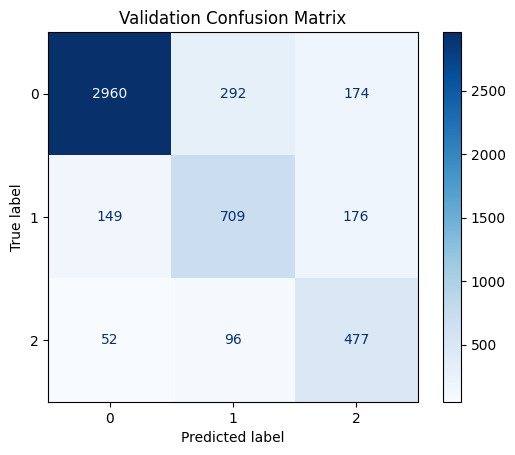

In [10]:
me.plot_confusion_matrix(metrics['confusion_matrix_val'], "Validation Confusion Matrix")

In [11]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      4281
           1       0.66      0.70      0.68      1293
           2       0.60      0.80      0.68       782

    accuracy                           0.82      6356
   macro avg       0.73      0.79      0.75      6356
weighted avg       0.84      0.82      0.83      6356



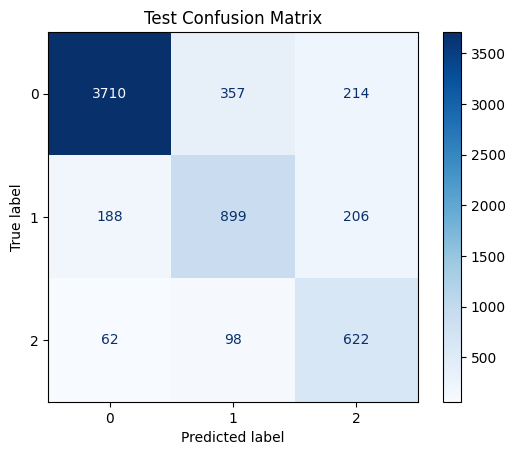

In [12]:
me.plot_confusion_matrix(metrics['confusion_matrix_test'], "Test Confusion Matrix")

--- Explanation for class 0 ---


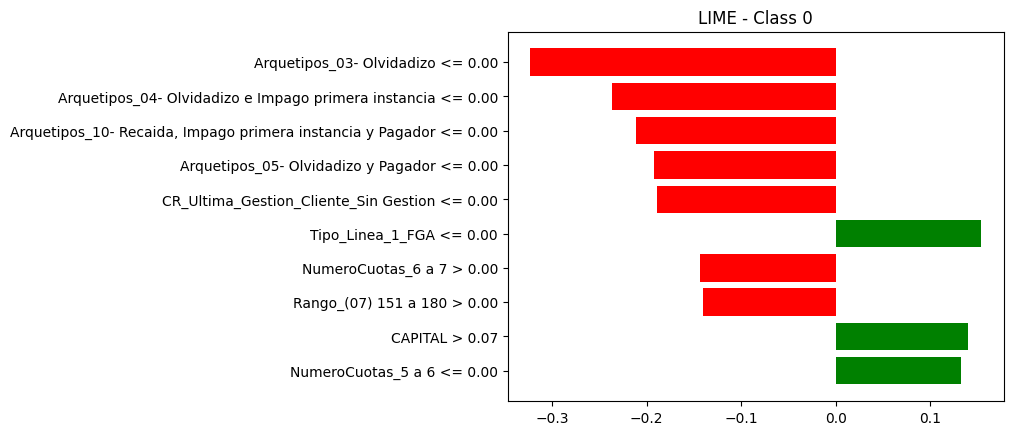

--- Explanation for class 1 ---


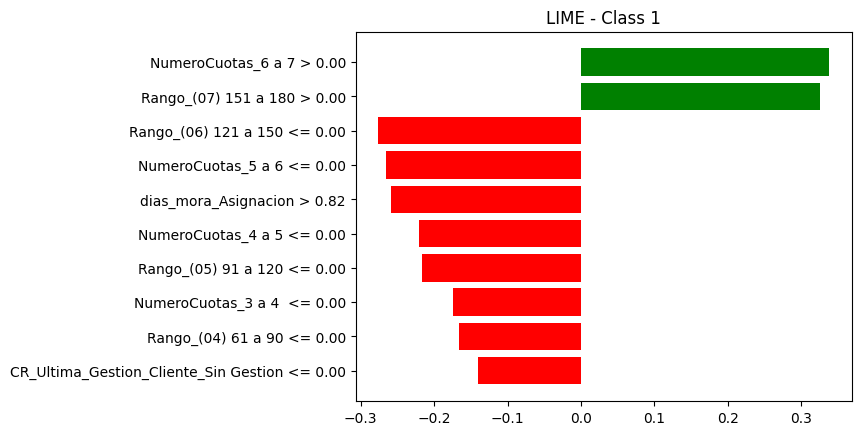

--- Explanation for class 2 ---


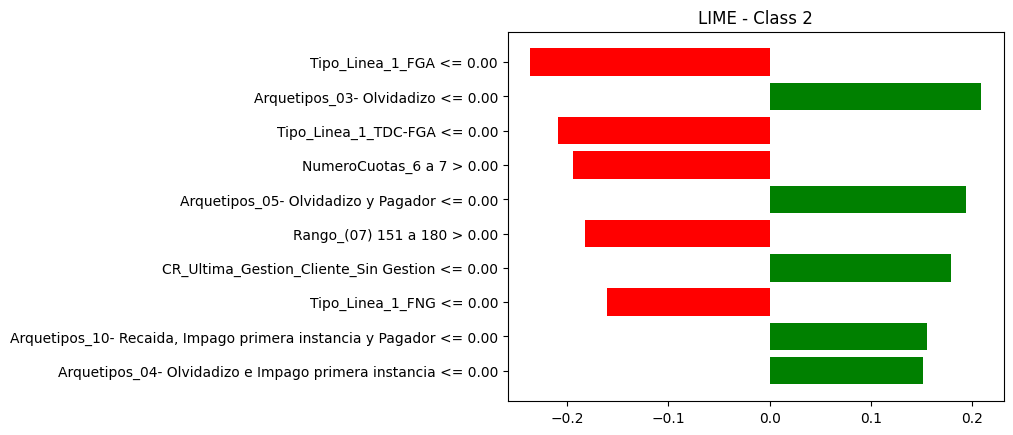

In [13]:
explainer, X_transformed = me.get_lime_explainer(model, metrics["X_train_fold"], metrics["y_train_fold"])
instance = X_transformed[10]

svc_clf = model.named_steps["classifier"]
predict_fn = lambda x: svc_clf.predict_proba(x)

exp = explainer.explain_instance(instance, predict_fn=predict_fn, labels=[0, 1, 2])
exp.show_in_notebook(show_table=True)

for class_label in exp.available_labels():
    print(f"--- Explanation for class {class_label} ---")
    fig = exp.as_pyplot_figure(label=class_label)
    plt.title(f"LIME - Class {class_label}")
    plt.show()


In [14]:
visualizations['optimization_history']

In [16]:
visualizations['f1_score_evolution']

In [17]:
visualizations['param_importances']

In [18]:
reporte.save(metrics, model_name="RL")


Report for model 'RL' saved:
   → CSV: ./Metrics/Metrics_RL.csv
   → JSON: ./Metrics/Metrics_RL.json


In [19]:
df = reporte.load()


Loaded 8 report(s)


In [20]:
df.query("Model == 'RL' and Type == 'val' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
96,RL,val,0,0.936,0.864,0.899
97,RL,val,1,0.646,0.686,0.665
98,RL,val,2,0.577,0.763,0.657
99,RL,val,macro avg,0.72,0.771,0.74
100,RL,val,weighted avg,0.833,0.815,0.822


In [21]:
df.query("Model == 'RL' and Type == 'test' and Class != 'global'").iloc[:, 0:6]


,Model,Type,Class,precision,recall,f1-score
102,RL,test,0,0.937,0.867,0.9
103,RL,test,1,0.664,0.695,0.679
104,RL,test,2,0.597,0.795,0.682
105,RL,test,macro avg,0.733,0.786,0.754
106,RL,test,weighted avg,0.84,0.823,0.829


In [23]:
df.query("Model == 'RL' and Type == 'val' and Class	== 'global'")[["Model", "Type", "accuracy", "log_loss", "auc"]]

,Model,Type,accuracy,log_loss,auc
101,RL,val,0.815,0.561,0.926


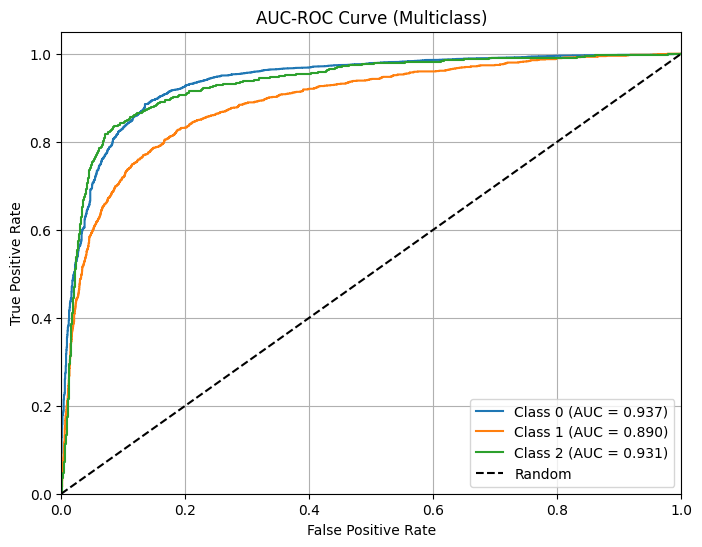

In [24]:
me.plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"],
)

In [25]:
model.named_steps['classifier'].get_params()

{'C': 11.24508672910605,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 10000,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}